In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import torch
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR100, CIFAR10
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader, TensorDataset

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

warnings.filterwarnings("ignore")

### Note

All Datasets will be of the format (N, C, H, W) with values between 0 and 1, unless stated otherwise.

This format is easier to deal with in PyTorch.

In [2]:
srmodel = torch.load('model/model_srresnet.pth')["model"]
srmodel = srmodel.cuda()

In [3]:
def generate_sr_dataset(dataset, model):
    sr_images, sr_targets = [], []    
    dataloader = DataLoader(dataset, batch_size=512, shuffle=False, num_workers=4)
    for (inputs, targets) in tqdm(dataloader):
        with torch.no_grad():
            inputs = inputs.cuda()
            inputs = Variable(inputs).float()
            sr_inputs = model(inputs)
            sr_images.append(sr_inputs.cpu().numpy().astype(np.float32))
            sr_targets.append(targets.numpy().astype(np.int64))

    sr_images = np.concatenate(sr_images, axis=0).clip(0, 1)
    sr_targets = np.concatenate(sr_targets, axis=0)

    sr_images = torch.from_numpy(sr_images)
    sr_targets = torch.from_numpy(sr_targets)
    sr_dataset = TensorDataset(sr_images, sr_targets)
    return sr_dataset

In [4]:
trainset = CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
sr_trainset = generate_sr_dataset(trainset, srmodel)
sr_testset = generate_sr_dataset(testset, srmodel)

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
bc_trainset = CIFAR100(root='./data', train=True, download=True, transform=transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
]))
bc_testset = CIFAR100(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
]))

Files already downloaded and verified
Files already downloaded and verified


In [7]:
sr_trainloader = DataLoader(sr_trainset, batch_size=64, shuffle=False, num_workers=4)
sr_testloader = DataLoader(sr_testset, batch_size=64, shuffle=False, num_workers=4)

bc_trainloader = DataLoader(bc_trainset, batch_size=64, shuffle=False, num_workers=4)
bc_testloader = DataLoader(bc_testset, batch_size=64, shuffle=False, num_workers=4)

torch.Size([64, 3, 128, 128]) torch.Size([64])


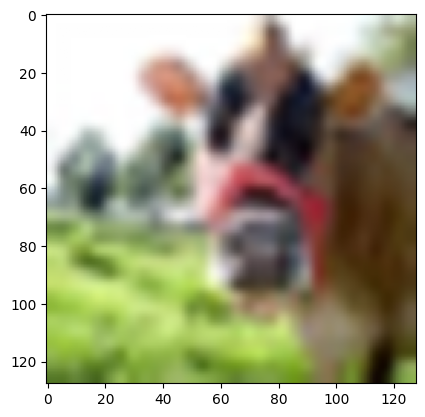

In [8]:
for i, (inputs, targets) in enumerate(bc_trainloader):
    print(inputs.shape, targets.shape)
    plt.imshow(inputs[0].permute(1, 2, 0))
    plt.show()
    break

torch.Size([64, 3, 128, 128]) torch.Size([64])


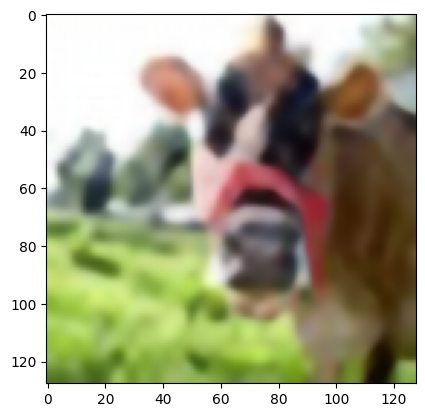

In [9]:
for i, (inputs, targets) in enumerate(sr_trainloader):
    print(inputs.shape, targets.shape)
    plt.imshow(inputs[0].permute(1, 2, 0))
    plt.show()
    break

### Training a CNN

In [10]:
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [11]:
def create_model(pretrain=True, out_channels=10):
    model = models.resnet18(pretrained=pretrain)
    model.fc = torch.nn.Linear(512, out_channels)
    model = model.cuda()
    return model


def train(model, trainloader, testloader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    accuracy = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(trainloader):
            inputs = inputs.cuda()
            targets = targets.cuda()
            inputs = Variable(inputs).float()
            targets = Variable(targets).long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        correct = 0
        total = 0
        with torch.no_grad():
            for (inputs, targets) in testloader:
                inputs = inputs.cuda()
                targets = targets.cuda()
                inputs = Variable(inputs).float()
                targets = Variable(targets).long()
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        print(f'Accuracy of the network on the 10000 test images: {(100 * correct / total):.2f} %')
        print('Loss on train set: ', running_loss / len(trainloader))
        accuracy.append(correct / total)
    return accuracy

In [12]:
model = create_model(True, 100)
bc_acc = train(model, bc_trainloader, bc_testloader, epochs=15)

torch.save(model.state_dict(), 'model/model_bc_finetune15_cifar100.pth')

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 67.99 %
Loss on train set:  2.051640098814464
Accuracy of the network on the 10000 test images: 72.77 %
Loss on train set:  0.8785587630384718
Accuracy of the network on the 10000 test images: 74.13 %
Loss on train set:  0.5796573285365958
Accuracy of the network on the 10000 test images: 74.86 %
Loss on train set:  0.38440167418945476
Accuracy of the network on the 10000 test images: 75.36 %
Loss on train set:  0.25011439158883697
Accuracy of the network on the 10000 test images: 75.22 %
Loss on train set:  0.15849369955118126
Accuracy of the network on the 10000 test images: 75.42 %
Loss on train set:  0.09937480637741744
Accuracy of the network on the 10000 test images: 75.51 %
Loss on train set:  0.06371678392071743
Accuracy of the network on the 10000 test images: 75.77 %
Loss on train set:  0.04303347143223104
Accuracy of the network on the 10000 test images: 75.97 %
Loss on train set:  0.030886881989534095
Accuracy of the network

In [13]:
model = create_model(True, 100)
sr_acc = train(model, sr_trainloader, sr_testloader, epochs=15)

torch.save(model.state_dict(), 'model/model_sr_finetune15_cifar100.pth')


  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 69.89 %
Loss on train set:  1.910031893674065
Accuracy of the network on the 10000 test images: 74.18 %
Loss on train set:  0.7962302443621408
Accuracy of the network on the 10000 test images: 75.64 %
Loss on train set:  0.5208138763390081
Accuracy of the network on the 10000 test images: 76.10 %
Loss on train set:  0.3403706008525532
Accuracy of the network on the 10000 test images: 76.33 %
Loss on train set:  0.2195393915152382
Accuracy of the network on the 10000 test images: 76.35 %
Loss on train set:  0.1403891506588177
Accuracy of the network on the 10000 test images: 76.53 %
Loss on train set:  0.08974369313053386
Accuracy of the network on the 10000 test images: 76.80 %
Loss on train set:  0.05846052635889834
Accuracy of the network on the 10000 test images: 76.83 %
Loss on train set:  0.0400260939224697
Accuracy of the network on the 10000 test images: 76.93 %
Loss on train set:  0.02890995495102328
Accuracy of the network on t

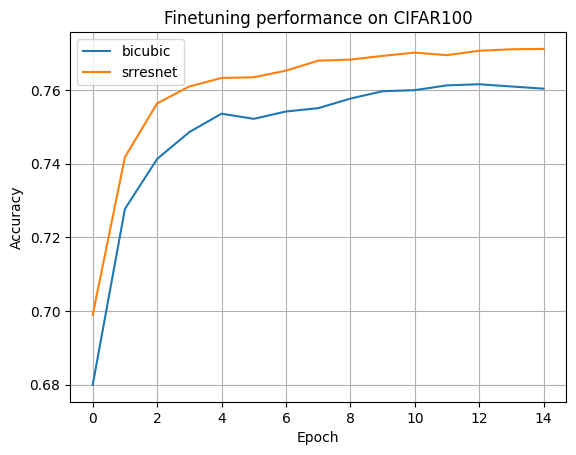

In [14]:
plt.plot(bc_acc, label='bicubic')
plt.plot(sr_acc, label='srresnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Finetuning performance on CIFAR100')
plt.legend()
plt.grid()
plt.show()

In [15]:
model = create_model(False, 100)
bc_acc = train(model, bc_trainloader, bc_testloader, epochs=100)

torch.save(model.state_dict(), 'model/model_bc_scratch100_cifar100.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 13.37 %
Loss on train set:  4.103602530706264
Accuracy of the network on the 10000 test images: 18.35 %
Loss on train set:  3.5762053096995636
Accuracy of the network on the 10000 test images: 22.65 %
Loss on train set:  3.2811215808019614


In [ ]:
model = create_model(False, 100)
sr_acc = train(model, sr_trainloader, sr_testloader, epochs=100)

torch.save(model.state_dict(), 'model/model_sr_scratch100_cifar100.pth')

In [ ]:
plt.plot(bc_acc, label='bicubic')
plt.plot(sr_acc, label='srresnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training performance on CIFAR100')
plt.legend()
plt.grid()
plt.show()